In [2]:
from catboost import  CatBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import make_pipeline

import random
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

c:\프로그램\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [29]:
data = pd.read_csv('../datasets/BankChurners_change.csv', encoding='CP949')
data = data.iloc[:,2:23]
data.drop('Customer_Age', axis=1, inplace=True)
np.random.seed(42)
random.seed(42)

In [30]:
object_columns = data.select_dtypes('object').columns

for i in object_columns:

    lb = LabelEncoder()
    lb.fit(data[i])
    data[i] = lb.transform(data[i])
    
    print(f'category : {np.unique(data[i])}\nclasses : {lb.classes_}\n')

input = data.iloc[:,1:]
target = data.iloc[:,0]

category : [0 1]
classes : ['Attrited Customer' 'Existing Customer']

category : [0 1]
classes : ['F' 'M']

category : [0 1 2 3 4 5 6]
classes : ['College' 'Doctorate' 'Graduate' 'High School' 'Post-Graduate'
 'Uneducated' 'Unknown']

category : [0 1 2 3]
classes : ['Divorced' 'Married' 'Single' 'Unknown']

category : [0 1 2 3 4 5]
classes : ['$120K +' '$40K - $60K' '$60K - $80K' '$80K - $120K' 'Less than $40K'
 'Unknown']

category : [0 1 2 3]
classes : ['Blue' 'Gold' 'Platinum' 'Silver']

category : [0 1 2 3 4]
classes : ['20대' '30대' '40대' '50대' '60대 이상']



## Under Sampling

In [34]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks]

for i in sampling:
    
    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    if i == OneSidedSelection:
        sampling = i(random_state=42)
    else:
        sampling = i()

    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by Under sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False)

Cat Model's score by Under sampling


,f1_score,recall,precision,accuracy
OneSidedSelection,0.982754,0.989406,0.976190,0.970879
TomekLinks,0.982754,0.989406,0.976190,0.970879
EditedNearestNeighbours,0.981668,0.977045,0.986334,0.969398
NeighbourhoodCleaningRule,0.981121,0.978811,0.983442,0.968411
AllKNN,0.979580,0.974102,0.985119,0.965943
RepeatedEditedNearestNeighbours,0.979241,0.971748,0.986850,0.965449
NearMiss,0.950046,0.912301,0.991049,0.919546


## Over Sampling

In [35]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTE, BorderlineSMOTE, ADASYN]
strategy_ = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in sampling:
    
    for strategy in strategy_:
        x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

        ss = StandardScaler()
        x_train_ss = ss.fit_transform(x_train)
        x_test_ss = ss.fit_transform(x_test)

        sampling = i(sampling_strategy=strategy, random_state=42)
        x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

        cat = CatBoostClassifier(random_state=42, verbose=0)
        cat.fit(x_train_ss, y_train)
        pred = cat.predict(x_test_ss)

        acc = accuracy_score(y_test, pred)
        recall = recall_score(y_test, pred)
        precision = precision_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        
        df.loc[i.__name__+'('+str(strategy)+')'] = [f1, recall, precision, acc]

print("Cat Model's score by Over sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by Over sampling


,f1_score,recall,precision,accuracy
SMOTE(0.3),0.979314,0.975280,0.983383,0.965449
BorderlineSMOTE(0.3),0.976148,0.963508,0.989124,0.960513
ADASYN(0.3),0.975187,0.959976,0.990887,0.959033
SMOTE(0.4),0.971806,0.953502,0.990826,0.953603
SMOTE(0.5),0.964513,0.935845,0.994994,0.942251
ADASYN(0.4),0.959513,0.927604,0.993695,0.934353
BorderlineSMOTE(0.4),0.956920,0.921719,0.994917,0.930405
BorderlineSMOTE(0.5),0.954392,0.917599,0.994260,0.926456
SMOTE(0.6),0.951767,0.911713,0.995501,0.922507
ADASYN(0.5),0.951385,0.909947,0.996776,0.922014


In [36]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTE, BorderlineSMOTE, ADASYN]

for i in sampling:

    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    sampling = i(random_state=42)
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by Over sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by Over sampling


,f1_score,recall,precision,accuracy
BorderlineSMOTE,0.911012,0.837552,0.998596,0.862784
SMOTE,0.900645,0.821660,0.996431,0.847976
ADASYN,0.897893,0.815185,0.999278,0.844521


## Combine Sampling

In [37]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
df = pd.DataFrame(columns=columns)

sampling = [SMOTETomek, SMOTEENN]

for i in sampling:

    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    sampling = i(random_state=42)
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    df.loc[sampling] = [f1, recall, precision, acc]

print("Cat Model's score by Combine sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False)

Cat Model's score by Combine sampling


,f1_score,recall,precision,accuracy
SMOTEENN(random_state=42),0.921469,0.856386,0.997258,0.877591
SMOTETomek(random_state=42),0.904057,0.826368,0.997868,0.852912


## Pipeline을 통한 Combine Sampling

In [38]:
strategy_ = [0.3, 0.4, 0.5]
columns = ['f1_score', 'recall', 'precision', 'accuracy']

df = pd.DataFrame(columns=columns)

under_sampling = [EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks]
over_sampling = [SMOTE, BorderlineSMOTE, ADASYN]

cat = CatBoostClassifier(random_state=42, verbose=0)

for over in over_sampling:

    for under in under_sampling:

        x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

        for strategy in strategy_:
            
            if under == OneSidedSelection:
                under_ = under(random_state=42)
            else:
                under_ = under()

            over_ = over(sampling_strategy=strategy, random_state=42)

            ss = StandardScaler()
            x_train_ss = ss.fit_transform(x_train)
            x_test_ss = ss.fit_transform(x_test)

            model = make_pipeline(over_, under_, cat)   
            model.fit(x_train_ss, y_train)
            pred = model.predict(x_test_ss)

            acc = accuracy_score(y_test, pred)
            recall = recall_score(y_test, pred)
            precision = precision_score(y_test, pred)
            f1 = f1_score(y_test, pred)

            df.loc[over.__name__+under.__name__+'('+str(strategy)+')'] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by sampling


,f1_score,recall,precision,accuracy
SMOTEOneSidedSelection(0.3),0.978635,0.970571,0.986834,0.964462
SMOTENeighbourhoodCleaningRule(0.3),0.978571,0.967628,0.989765,0.964462
SMOTETomekLinks(0.3),0.978055,0.970571,0.985655,0.963475
BorderlineSMOTEOneSidedSelection(0.3),0.976827,0.967628,0.986203,0.961500
BorderlineSMOTETomekLinks(0.3),0.976786,0.965862,0.987959,0.961500
SMOTEEditedNearestNeighbours(0.3),0.975552,0.962919,0.988520,0.959526
SMOTEAllKNN(0.3),0.974022,0.959976,0.988485,0.957058
BorderlineSMOTENeighbourhoodCleaningRule(0.3),0.973975,0.958211,0.990268,0.957058
BorderlineSMOTEEditedNearestNeighbours(0.3),0.973345,0.956445,0.990854,0.956071
SMOTERepeatedEditedNearestNeighbours(0.3),0.973102,0.958211,0.988464,0.955577


## Under, Over, Combine Sampling과 Pipeline을 통한 Combine Sampling 전체 결과

In [39]:
sampling = [EditedNearestNeighbours,RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks, SMOTE, BorderlineSMOTE, ADASYN, SMOTETomek, SMOTEENN]

for i in sampling:
    x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

    ss = StandardScaler()
    x_train_ss = ss.fit_transform(x_train)
    x_test_ss = ss.fit_transform(x_test)

    if i in [OneSidedSelection, SMOTE, BorderlineSMOTE, ADASYN, SMOTETomek, SMOTEENN]:
        sampling = i(random_state=42)
    else:
        sampling = i()
        
    x_train_ss, y_train = sampling.fit_resample(x_train_ss, y_train)

    cat = CatBoostClassifier(random_state=42, verbose=0)
    cat.fit(x_train_ss, y_train)
    pred = cat.predict(x_test_ss)

    acc = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred)
    precision = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    df.loc[i.__name__] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
df.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
df.head(10)

Cat Model's score by sampling


,f1_score,recall,precision,accuracy
OneSidedSelection,0.982754,0.989406,0.976190,0.970879
TomekLinks,0.982754,0.989406,0.976190,0.970879
EditedNearestNeighbours,0.981668,0.977045,0.986334,0.969398
NeighbourhoodCleaningRule,0.981121,0.978811,0.983442,0.968411
AllKNN,0.979580,0.974102,0.985119,0.965943
RepeatedEditedNearestNeighbours,0.979241,0.971748,0.986850,0.965449
SMOTEOneSidedSelection(0.3),0.978635,0.970571,0.986834,0.964462
SMOTENeighbourhoodCleaningRule(0.3),0.978571,0.967628,0.989765,0.964462
SMOTETomekLinks(0.3),0.978055,0.970571,0.985655,0.963475
BorderlineSMOTEOneSidedSelection(0.3),0.976827,0.967628,0.986203,0.961500


## No Sampling

In [43]:
columns = ['f1_score', 'recall', 'precision', 'accuracy']
No_Sampling = pd.DataFrame(columns=columns)

random.seed(42)

x_train, x_test, y_train, y_test = train_test_split(input, target, test_size=0.2, random_state=42)

ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

## CatBoost는 cat_features에 문자열 인덱스를 넣어주면 알아서 라벨링해주는 기능이 있다.
cat = CatBoostClassifier(random_state=42,verbose=0)
cat.fit(x_train, y_train) #, cat_features=object_col
pred = cat.predict(x_test)

acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)

No_Sampling.loc['No Sampling'] = [f1, recall, precision, acc]

print("Cat Model's score by sampling")
No_Sampling.sort_values(['f1_score', 'recall', 'precision', 'accuracy'], ascending=False, inplace=True)
No_Sampling.head(10)

Cat Model's score by sampling


,f1_score,recall,precision,accuracy
No Sampling,0.982723,0.98764,0.977855,0.970879


In [48]:
x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.fit_transform(x_test)

tl = TomekLinks()
x_train_ss, y_train = tl.fit_resample(x_train_ss, y_train)

cat = CatBoostClassifier(random_state=42, verbose=0)
cat.fit(x_train_ss, y_train)
pred = cat.predict(x_test_ss)

acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f1)

0.9827535808243203


c:\프로그램\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'CatBoost Feature Importance\n')

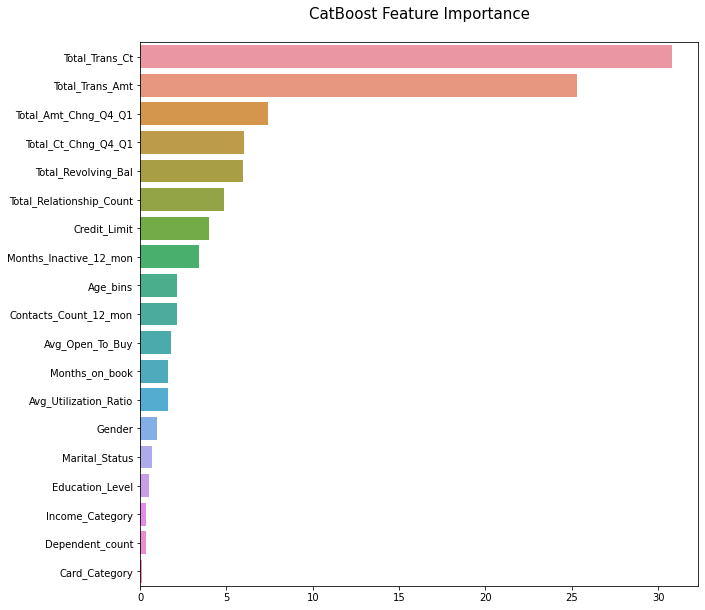

In [49]:
feature_importance = pd.Series(cat.feature_importances_, index=x_train.columns)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10,10))
sns.barplot(feature_importance.values, feature_importance.index)
plt.title('CatBoost Feature Importance\n', fontsize=15)

In [50]:
columns = ['Attrited Customer', 'Existing Customer']
df = pd.DataFrame(columns=columns)

x_train, x_test, y_train, y_test = train_test_split(input, target, random_state=42, test_size=0.2)

ss = StandardScaler()
x_train_ss = ss.fit_transform(x_train)
x_test_ss = ss.fit_transform(x_test)
df.loc['Before Sampling'] = [sum(y_train==0), sum(y_train==1)]

tl = TomekLinks()
x_train_ss, y_train = tl.fit_resample(x_train_ss, y_train)
df.loc['After Sampling'] = [sum(y_train==0), sum(y_train==1)]
print('TomekLinks Before After Data Compare')
df



TomekLinks Before After Data Compare


,Attrited Customer,Existing Customer
Before Sampling,1300,6801
After Sampling,1300,6663
